In [192]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from treelib import Tree
import operator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from scipy.stats import t as t_dist
from scipy.stats import norm, chi2
import pickle
import pydot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import auc

In [193]:
class Node:
    def __init__(self, name, feature=None, threshold=None, left_child=None, right_child=None, is_leaf=False, value=-1, depth=-1):
        self.feature = feature
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.is_leaf = is_leaf
        self.value = value
        self.name = name
        self.depth = depth
        self.probabilities = {}

In [194]:
class MyDecisionTree:
    def __init__(self, min_samples=1, max_depth=-1, max_thresholds=None, min_unique_values=None, num_random_columns=None):
        self.root_node = Node('root', depth=0)
        self.node_count = 0
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.max_thresholds = max_thresholds
        self.min_unique_values = min_unique_values
        self.num_random_columns = num_random_columns
        self.classes = []
    
    def predict(self, X, cols_d):
        
        Y_pred = []
        for i in range(len(X)):

            x_i = X[i]
            # print(x_i[0])
            curr_node = self.root_node
            predicted_y = np.array(self.predict_util(x_i, curr_node, cols_d))
            # print(predicted_y)
            Y_pred.append(predicted_y)

        return np.array(Y_pred)
    
    def predict_util(self, x, curr_node, cols_d):
        
        # print(curr_node.feature)
        if(curr_node.is_leaf):
            return curr_node.value
        if x[cols_d[curr_node.feature]] <= curr_node.threshold:
            if curr_node.is_leaf:
                return curr_node.value
            return self.predict_util(x, curr_node.left_child, cols_d)
        else:
            if curr_node.is_leaf:
                return curr_node.value
            return self.predict_util(x, curr_node.right_child, cols_d)

    def predict_proba(self, X, cols_d):
        
        prob_pred = []
        for i in range(len(X)):

            x_i = X[i]
            # print(x_i[0])
            curr_node = self.root_node
            predicted_probs = self.predict_proba_util(x_i, curr_node, cols_d)
            class_probs = {}
            for label in self.classes:
                if(label in predicted_probs.keys()):
                    class_probs[label] = predicted_probs[label]
                else:
                    class_probs[label] = 0
            # print(predicted_y)
            prob_pred.append(class_probs)

        return np.array(prob_pred)

    def predict_proba_util(self, x, curr_node, cols_d):
        
        # print(curr_node.feature)
        if(curr_node.is_leaf):
            return curr_node.probabilities
        if x[cols_d[curr_node.feature]] <= curr_node.threshold:
            if curr_node.is_leaf:
                return curr_node.probabilities
            return self.predict_proba_util(x, curr_node.left_child, cols_d)
        else:
            if curr_node.is_leaf:
                return curr_node.probabilities
            return self.predict_proba_util(x, curr_node.right_child, cols_d)

    def fit(self, X, Y):
        unq_classes = np.unique(Y)
        self.classes = unq_classes
        self.fit_util(X, Y, self.root_node)


    def fit_util(self, X, Y, current_node):
        if np.unique(Y).shape[0] == 1:
            #TODO probability
            current_node.is_leaf = True
            unq, counts = np.unique(Y, return_counts=True)
            max_freq_idx = np.argmax(counts).flatten()
            current_node.value = unq[max_freq_idx].squeeze()
            current_node.name = f'leaf {current_node.value} {self.node_count}'
            self.node_count += 1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}
            return
            
        scores = []
        num_random_columns = len(X.columns)
        if self.num_random_columns is not None:
            num_random_columns = self.num_random_columns
        random_columns = X.columns.to_numpy()[np.random.permutation(len(X.columns))[:num_random_columns]]

        if(self.num_random_columns is None):
            random_columns = X.columns
        # print(random_columns)
        for column in random_columns:
            X_train = X[column].to_numpy()
            X_train = X_train.reshape(X_train.shape[0], 1)
            clf = LogisticRegression(random_state=0, max_iter=100)
            clf.fit(X_train, Y)
            # pred_Y = clf.predict(X_train)
            # precision = precision_score(pred_Y, Y)
            score = clf.score(X_train, Y)
            # print(precision)
            scores.append(score)
            
        scores = np.array(scores)
        best_feature = X.columns[np.argmax(scores)]
        best_feature_values = np.unique(X[best_feature])
        best_feature_values.sort()

        partition = self.get_partition(X, Y, best_feature, best_feature_values, current_node.depth)
        
        if partition == None:
            #TODO probability
            current_node.is_leaf = True
            unq, counts = np.unique(Y, return_counts=True)
            max_freq_idx = np.argmax(counts).flatten()
            current_node.value = unq[max_freq_idx].squeeze()
            current_node.name = f'leaf {current_node.value} {self.node_count}'
            self.node_count += 1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}
            return
            
        (X_left, Y_left), (X_right, Y_right), threshold = partition
        current_node.threshold = threshold
        current_node.feature = best_feature
        current_node.name = f'{best_feature} {threshold} {self.node_count}'
        self.node_count += 1
        current_node.left_child = Node('No name', depth=current_node.depth + 1)
        current_node.right_child = Node('No name', depth=current_node.depth + 1)

        self.fit_util(X_left, Y_left, current_node.left_child)
        self.fit_util(X_right, Y_right, current_node.right_child)

        

    def do_split(self, X, thresh):
        """
            Split the data at a node based on threshold
        """

        left_child_ids = np.where(X <= thresh, True, False)
        right_child_ids = np.where(X > thresh, True, False)
        return left_child_ids, right_child_ids
    
    def find_entropy(self, Y):
        probs = []
        possible_classes, counts = np.unique(Y, return_counts=True)
        sort_indices = np.argsort(possible_classes)
        possible_classes = possible_classes[sort_indices]
        counts = counts[sort_indices]
        
        for class_label, count in zip(possible_classes, counts):
            probs.append(count/Y.shape[0])
        
        entropy = 0
        for prob in probs:
            entropy -= prob*np.log2(prob)
        
        return entropy

    def get_partition(self, X, Y, feature, thresholds, current_node_depth):
        '''
            This function should return left and right
            partitions according to appropritate
            partitioning algorithm. Return None if all
            data has same label
        '''
        
        # if only 1 class available at a node OR MIN_SAMPLES left at a node - Leaf Node reached
        if(len(Y) < self.min_samples):
            return None
        if(current_node_depth == self.max_depth):
            return None
        
        best_info_gain = -float('inf')
        best_thresh = thresholds[0]      
        threshold_cnt = len(thresholds)  
        if self.max_thresholds is not None:
            threshold_cnt = self.max_thresholds
        min_unique_values = len(thresholds)

        if self.min_unique_values is not None:
            min_unique_values = self.min_unique_values
        
        # print("Now thresholding!")
        for thresh in (thresholds[:-1] if len(thresholds) <= min_unique_values else thresholds[:-1:len(thresholds) // threshold_cnt]):

            left_child_ids, right_child_ids = self.do_split(X[feature].to_numpy(), thresh)

            parent_pts = X.shape[0]
            left_child_pts = len(left_child_ids)
            right_child_pts = len(right_child_ids)

            info_gain = self.find_entropy(Y) - (left_child_pts / parent_pts) * self.find_entropy(Y[left_child_ids]) - (right_child_pts / parent_pts) * self.find_entropy(Y[right_child_ids])

            if(info_gain > best_info_gain):

                best_info_gain = info_gain
                best_thresh = thresh
        
        # partition according to best threshold
        best_left_ids, best_right_ids = self.do_split(X[feature].to_numpy(), best_thresh)
        # print(len(Y[best_left_ids]), len(Y[best_right_ids]))
        if(len(Y[best_left_ids]) == 0 or len(Y[best_right_ids]) == 0):
            # print(len(Y[best_left_ids]), len(Y[best_right_ids]))
            return None
        return (X[best_left_ids], Y[best_left_ids]), (X[best_right_ids], Y[best_right_ids]), best_thresh
    
    def print_tree(self):
        tree = Tree()
        self.print_tree_util(self.root_node, tree)
        tree.show()
        return tree

    def print_tree_util(self, root, tree, parent=None):
        if parent is not None:
            tree.create_node(root.name, root.name, parent=parent.name)
        else:
            tree.create_node(root.name, root.name)
        if root.is_leaf:
            return
        self.print_tree_util(root.left_child, tree, root)
        self.print_tree_util(root.right_child, tree, root)


In [195]:
class Node2:
    def __init__(self, name, feature=None, threshold=None, left_child1=None, left_child2=None, right_child1=None, right_child2=None, is_leaf=False, value=-1, depth=-1):
        self.feature = feature
        self.threshold = threshold
        self.left_child1 = left_child1
        self.left_child2 = left_child2
        self.right_child1 = right_child1
        self.right_child2 = right_child2
        self.is_leaf = is_leaf
        self.value = value
        self.name = name
        self.depth = depth
        self.probabilities = {}
    

In [196]:
class MyDecisionTree2:
    def __init__(self, min_samples=1, max_depth=-1, max_thresholds=None, min_unique_values=None, num_random_columns=None):
        self.root_node = Node2('root', depth=0)
        self.node_count = 0
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.max_thresholds = max_thresholds
        self.min_unique_values = min_unique_values
        self.num_random_columns = num_random_columns
        self.classes = []
    
    def predict_proba(self, X, cols_d):
        
        prob_pred = []
        for i in range(len(X)):

            x_i = X[i]
            # print(x_i[0])
            curr_node = self.root_node
            predicted_probs = self.predict_proba_util(x_i, curr_node, cols_d)
            class_probs = {}
            for label in self.classes:
                if(label in predicted_probs.keys()):
                    class_probs[label] = predicted_probs[label]
                else:
                    class_probs[label] = 0
            # print(predicted_y)
            prob_pred.append(class_probs)

        return np.array(prob_pred)

    def predict_proba_util(self, x, curr_node, cols_d):
        
        if(curr_node.is_leaf):
            return curr_node.probabilities
        if x[cols_d[curr_node.feature[0]]] <= curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] <= curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.probabilities
            return self.predict_proba_util(x, curr_node.left_child1, cols_d)

        if x[cols_d[curr_node.feature[0]]] > curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] <= curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.probabilities
            return self.predict_proba_util(x, curr_node.left_child2, cols_d)

        if x[cols_d[curr_node.feature[0]]] <= curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] > curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.probabilities
            return self.predict_proba_util(x, curr_node.right_child1, cols_d)

        elif x[cols_d[curr_node.feature[0]]] > curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] > curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.probabilities
            return self.predict_proba_util(x, curr_node.right_child2, cols_d)

    def predict(self, X, cols_d):
        
        Y_pred = []
        for i in range(len(X)):

            x_i = X[i]
            # print(x_i[0])
            curr_node = self.root_node
            predicted_y = np.array(self.predict_util(x_i, curr_node, cols_d))
            # print(predicted_y)
            Y_pred.append(predicted_y)

        return np.array(Y_pred)

    def predict_util(self, x, curr_node, cols_d):
        
        if(curr_node.is_leaf):
            return curr_node.value
        if x[cols_d[curr_node.feature[0]]] <= curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] <= curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.value
            return self.predict_util(x, curr_node.left_child1, cols_d)

        if x[cols_d[curr_node.feature[0]]] > curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] <= curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.value
            return self.predict_util(x, curr_node.left_child2, cols_d)

        if x[cols_d[curr_node.feature[0]]] <= curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] > curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.value
            return self.predict_util(x, curr_node.right_child1, cols_d)

        elif x[cols_d[curr_node.feature[0]]] > curr_node.threshold[0] and x[cols_d[curr_node.feature[1]]] > curr_node.threshold[1]:
            if curr_node.is_leaf:
                return curr_node.value
            return self.predict_util(x, curr_node.right_child2, cols_d)
    

    def fit(self, X, Y):
        unq_classes = np.unique(Y)
        self.classes = unq_classes
        self.fit_util(X, Y, self.root_node)


    def fit_util(self, X, Y, current_node):
        if np.unique(Y).shape[0] == 1:
            #TODO probability
            current_node.is_leaf = True
            unq, counts = np.unique(Y, return_counts=True)
            max_freq_idx = np.argmax(counts).flatten()
            current_node.value = unq[max_freq_idx].squeeze()
            current_node.name = f'leaf {current_node.value} {self.node_count}'
            self.node_count += 1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}
            return
            
        scores = {}
        num_random_columns = len(X.columns)
        if self.num_random_columns is not None:
            num_random_columns = self.num_random_columns
        random_columns = X.columns.to_numpy()[np.random.permutation(len(X.columns))[:num_random_columns]]
        if(self.num_random_columns is None):
            random_columns = X.columns
        for column1 in random_columns:
            for column2 in random_columns:
                column = [column1, column2]
                X_train = X[column].to_numpy()
                X_train = X_train.reshape(X_train.shape[0], 2)
                clf = LogisticRegression(random_state=0)
                clf.fit(X_train, Y)
                score = clf.score(X_train, Y)
                scores[(column1, column2)] = score
            

        scores_sorted = dict( sorted(scores.items(), key=operator.itemgetter(1),reverse=True))
        best_feature_set = list(scores_sorted.keys())[0]
        best_feature1_values = np.unique(X[best_feature_set[0]])
        best_feature2_values = np.unique(X[best_feature_set[1]])

        best_feature1_values.sort()
        best_feature2_values.sort()

        partition = self.get_partition(X, Y, best_feature_set[0], best_feature_set[1], best_feature1_values, best_feature2_values, current_node.depth)
        
        if partition == None:
            #TODO probability
            current_node.is_leaf = True
            unq, counts = np.unique(Y, return_counts=True)
            max_freq_idx = np.argmax(counts).flatten()
            current_node.value = unq[max_freq_idx].squeeze()
            current_node.name = f'leaf {current_node.value} {self.node_count}'
            self.node_count += 1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}
            return
            
        (X_left1, Y_left1), (X_left2, Y_left2), (X_right1, Y_right1), (X_right2, Y_right2), threshold1, threshold2 = partition

        threshold = [threshold1, threshold2]
        # print("Thresholds: ",threshold)
        current_node.threshold = threshold
        current_node.feature = best_feature_set
        current_node.name = f'{best_feature_set} {threshold} {self.node_count}'
        self.node_count += 1
        current_node.left_child1 = Node2('unnamed', depth=current_node.depth + 1)
        current_node.left_child2 = Node2('unnamed', depth=current_node.depth + 1)
        current_node.right_child1 = Node2('unnamed', depth=current_node.depth + 1)
        current_node.right_child2 = Node2('unnamed', depth=current_node.depth + 1)

        unq, counts = np.unique(Y, return_counts=True)
        max_freq_idx = np.argmax(counts).flatten()
        if(X_left1.shape[0] == 0):
            #TODO probability
            current_node.left_child1.is_leaf = True
            current_node.left_child1.value = unq[max_freq_idx].squeeze()
            current_node.left_child1.name = f'leaf {current_node.left_child1.value} {self.node_count}'
            self.node_count+=1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))} 
            # return
        
        if(X_left2.shape[0] == 0):
            #TODO probability
            current_node.left_child2.is_leaf = True
            current_node.left_child2.value = unq[max_freq_idx].squeeze()
            current_node.left_child2.name = f'leaf {current_node.left_child2.value} {self.node_count}'
            self.node_count+=1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}
            # return
        
        if(X_right1.shape[0] == 0):
            #TODO probability
            current_node.right_child1.is_leaf = True
            current_node.right_child1.value = unq[max_freq_idx].squeeze()
            current_node.right_child1.name = f'leaf {current_node.right_child1.value} {self.node_count}'
            self.node_count+=1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}   
            # return     
        
        if(X_right2.shape[0] == 0):
            #TODO probability
            current_node.right_child2.is_leaf = True
            current_node.right_child2.value = unq[max_freq_idx].squeeze()
            current_node.right_child2.name = f'leaf {current_node.right_child2.value} {self.node_count}'
            self.node_count+=1
            probs = counts / np.sum(counts)
            current_node.probabilities = {unq[i]:probs[i] for i in range(len(unq))}  
            # return                  
          
        if(X_left1.shape[0] != 0):
            self.fit_util(X_left1, Y_left1, current_node.left_child1)
        
        if(X_left2.shape[0] != 0):
            self.fit_util(X_left2, Y_left2, current_node.left_child2)
        
        if(X_right1.shape[0] != 0):
            self.fit_util(X_right1, Y_right1, current_node.right_child1)
        
        if(X_right2.shape[0] != 0):
            self.fit_util(X_right2, Y_right2, current_node.right_child2)


    def do_split(self, X, thresh):
        """
            Split the data at a node based on threshold
        """

        left_child_ids = np.where(X <= thresh, True, False)
        right_child_ids = np.where(X > thresh, True, False)
        return left_child_ids, right_child_ids

    def do_split_final(self, X1, X2, thresh1, thresh2):

        """
            Split according to the best thresholds for the 2 features
        """   

        left1_ids = np.where(np.logical_and(X1 <= thresh1, X2 <= thresh2), True, False)
        left2_ids = np.where(np.logical_and(X1 > thresh1, X2 <= thresh2), True, False)
        right1_ids = np.where(np.logical_and(X1 <= thresh1, X2 > thresh2), True, False)
        right2_ids = np.where(np.logical_and(X1 > thresh1, X2 > thresh2), True, False)

        return left1_ids, left2_ids, right1_ids, right2_ids

    def find_entropy(self, Y):
        probs = []
        possible_classes, counts = np.unique(Y, return_counts=True)
        sort_indices = np.argsort(possible_classes)
        possible_classes = possible_classes[sort_indices]
        counts = counts[sort_indices]
        
        for class_label, count in zip(possible_classes, counts):
            probs.append(count/Y.shape[0])
        
        entropy = 0
        for prob in probs:
            entropy -= prob*np.log2(prob)
        
        return entropy
    
    def find_best_thresh_info_gain(self, thresholds1, thresholds2, X, Y, feature1, feature2):
        """
            This function finds the best threshold and info gain for a given feature
        """
        best_info_gain = -float('inf')
        best_thresh1 = thresholds1[0]   
        best_thresh2 = thresholds2[0]     
        threshold_cnt_1 = len(thresholds1)
        threshold_cnt_2  = len(thresholds2)
        if self.max_thresholds is not None:
            threshold_cnt_1, threshold_cnt_2 = self.max_thresholds, self.max_thresholds
        min_unique_values_1 = len(thresholds1)
        min_unique_values_2 = len(thresholds2)

        if self.min_unique_values is not None:
            min_unique_values_1, min_unique_values_2 = self.min_unique_values, self.min_unique_values
        
        # print("Now thresholding!")
        for thresh1 in (thresholds1[:-1] if len(thresholds1) <= min_unique_values_1 else thresholds1[:-1:len(thresholds1) // threshold_cnt_1]):
            for thresh2 in (thresholds2[:-1] if len(thresholds2) <= min_unique_values_2 else thresholds2[:-1:len(thresholds2) // threshold_cnt_2]):
                left_child1_ids, left_child2_ids,  right_child1_ids, right_child2_ids = self.do_split_final(X[feature1].to_numpy(),X[feature2].to_numpy(), thresh1, thresh2)

                parent_pts = X.shape[0]
                left_child1_pts = len(left_child1_ids)
                left_child2_pts = len(left_child2_ids)
                right_child1_pts = len(right_child1_ids)
                right_child2_pts = len(right_child2_ids)

                info_gain = self.find_entropy(Y) - (left_child1_pts / parent_pts) * self.find_entropy(Y[left_child1_ids]) - (left_child2_pts / parent_pts) * self.find_entropy(Y[left_child2_ids]) - (right_child1_pts / parent_pts) * self.find_entropy(Y[right_child1_ids]) - (right_child2_pts / parent_pts) * self.find_entropy(Y[right_child2_ids])
                
                if(info_gain > best_info_gain):

                    best_info_gain = info_gain
                    best_thresh1 = thresh1
                    best_thresh2 = thresh2

        
        return best_thresh1, best_thresh2, best_info_gain

    def get_partition(self, X, Y, feature1, feature2, thresholds1, thresholds2, current_node_depth):
        '''
            This function should return left and right
            partitions according to appropritate
            partitioning algorithm. Return None if all
            data has same label
        '''
        
        # if only 1 class available at a node OR MIN_SAMPLES left at a node - Leaf Node reached
        if(len(Y) < self.min_samples):
            return None
        if(current_node_depth == self.max_depth):
            return None
        
        best_thresh1, best_thresh2, best_info_gain = self.find_best_thresh_info_gain(thresholds1, thresholds2, X, Y, feature1, feature2)

        # partition according to best threshold
        best_left_ids1, best_left_ids2, best_right_ids1, best_right_ids2 = self.do_split_final(X[feature1].to_numpy(), X[feature2].to_numpy(), best_thresh1, best_thresh2)

        # print(len(Y[best_left_ids1]), len(Y[best_left_ids2]), len(Y[best_right_ids1]) , len(Y[best_right_ids2]))

        count_0 = 0
        if(len(Y[best_left_ids1]) == 0):
            count_0 += 1
        if(len(Y[best_left_ids2]) == 0):
            count_0 += 1
        if(len(Y[best_right_ids1]) == 0):
            count_0 += 1
        if(len(Y[best_right_ids2]) == 0):
            count_0 += 1

        if(count_0 == 3):
            print(len(Y[best_left_ids1]), len(Y[best_left_ids2]), len(Y[best_right_ids1]) , len(Y[best_right_ids2]))
            return None

        return (X[best_left_ids1], Y[best_left_ids1]), (X[best_left_ids2], Y[best_left_ids2]), (X[best_right_ids1], Y[best_right_ids1]),(X[best_right_ids2], Y[best_right_ids2]), best_thresh1, best_thresh2    
    
    def print_tree(self):
        tree = Tree()
        self.print_tree_util(self.root_node, tree)
        tree.show()
        return tree

    def print_tree_util(self, root, tree, parent=None):
        if parent is not None:
            # print(root.name)
            tree.create_node(root.name, root.name, parent=parent.name)
        else:
            # print(root.name)
            tree.create_node(root.name, root.name)
        if root.is_leaf:
            return
        self.print_tree_util(root.left_child1, tree, root)
        self.print_tree_util(root.left_child2, tree, root)
        self.print_tree_util(root.right_child1, tree, root)
        self.print_tree_util(root.right_child2, tree, root)


In [197]:
def visualize_tree(tree, path):

    tree.to_graphviz(path+".dot")
    (graph,) = pydot.graph_from_dot_file(path+'.dot')
    graph.write_png(path + '.png')

In [198]:
def plot_roc_curve(true_y, y_prob, path):


    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.savefig(path)
    
def plot_multiclass_auc_roc(X_test, Y_test, cols_d, model, path):
    classes_list = list(np.unique(Y_test))
    y = label_binarize(Y_test, classes=classes_list)
    num_classes = y.shape[1]
    y_probs = model.predict_proba(np.array(X_test.to_numpy()), cols_d)
    prob_list = np.array([list(prob_dict.values()) for prob_dict in y_probs])
    
    fpr = dict()
    tpr = dict()
    roc_auc_score = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], prob_list[:, i])
        roc_auc_score[i] = auc(fpr[i], tpr[i])

    colors = cycle(['red', 'green', 'blue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label=f"ROC curve of class {i + 1} , AUC = {roc_auc_score[i]}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.savefig(path)

In [82]:
# def paired_t_test(p):
#     p_hat = np.mean(p)
#     n = len(p)
#     den = np.sqrt(sum([(diff - p_hat)**2 for diff in p]) / (n - 1))
#     t = (p_hat * (n**(1/2))) / den
    
#     p_value = t_dist.sf(t, n-1)*2
    
#     return t, p_value

# def z_test(acc1, acc2, n):

#     z, p = proportion_difference(acc1, acc2, n_1 = n)
#     return z,p

# def mcnamer_test(Y_test, Y_pred1, Y_pred2):
#     b = sum(np.logical_and((Y_pred2 != Y_test), (Y_pred1 == Y_test)))
#     c = sum(np.logical_and((Y_pred1 != Y_test), (Y_pred2 == Y_test)))

#     chi_2 = ((np.abs(b-c)-1)**2)/(b+c)
#     p = chi2.sf(chi_2, 1)

#     return chi_2, p

In [199]:
df_cancer = pd.read_csv('../data/preprocessed-data/dataset1.csv')

In [200]:
X_cancer = df_cancer.drop(['Unnamed: 0','Biopsy'], axis=1)
Y_cancer = df_cancer['Biopsy'].to_numpy()
X_train_cancer, X_test_cancer, Y_train_cancer, Y_test_cancer = train_test_split(X_cancer, Y_cancer, test_size=0.2, random_state = 42, stratify=Y_cancer)
print(X_train_cancer.shape)
print(np.unique(Y_train_cancer, return_counts=True))
print(np.unique(Y_test_cancer, return_counts=True))

(664, 31)
(array([0, 1], dtype=int64), array([621,  43], dtype=int64))
(array([0, 1], dtype=int64), array([155,  11], dtype=int64))


In [201]:
cols_cancer = X_cancer.columns
cols_d_cancer = {}
id=0
for col in cols_cancer:
    cols_d_cancer[col] = id
    id+=1

In [208]:
dt_cancer1 = MyDecisionTree(max_depth=5)
dt_cancer1.fit(X_train_cancer, Y_train_cancer)
Y_pred1_cancer = dt_cancer1.predict(np.array(X_test_cancer.to_numpy()), cols_d_cancer)
accuracy1 = accuracy_score(Y_pred1_cancer, Y_test_cancer)
precision1 = precision_score(Y_pred1_cancer, Y_test_cancer)
recall1 = recall_score(Y_pred1_cancer, Y_test_cancer)
f1 = f1_score(Y_pred1_cancer, Y_test_cancer)
print("One-feature split accuracy: ", accuracy1)
print("One-feature split Precision: ", precision1)
print("One-feature split Recall: ", recall1)
print("One-feature split F1-Score: ", f1)
print("Classification Report: ")
print(classification_report(Y_pred1_cancer, Y_test_cancer))


One-feature split accuracy:  0.9759036144578314
One-feature split Precision:  0.9090909090909091
One-feature split Recall:  0.7692307692307693
One-feature split F1-Score:  0.8333333333333333
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       153
           1       0.91      0.77      0.83        13

    accuracy                           0.98       166
   macro avg       0.94      0.88      0.91       166
weighted avg       0.98      0.98      0.97       166



In [209]:
tree = dt_cancer1.print_tree()

Schiller 0 0
├── Age 13 1
│   ├── Age 59 3
│   │   ├── Age 52 4
│   │   │   ├── Age 50 5
│   │   │   │   ├── leaf 0 6
│   │   │   │   └── leaf 0 7
│   │   │   └── leaf 0 8
│   │   └── leaf 0 9
│   └── leaf 0 2
└── First sexual intercourse 23.0 10
    ├── First sexual intercourse 22.0 11
    │   ├── STDs:syphilis 0.0 12
    │   │   ├── IUD (years) 11.0 13
    │   │   │   ├── leaf 0 15
    │   │   │   └── leaf 1 14
    │   │   └── leaf 0 16
    │   └── leaf 1 17
    └── leaf 1 18



In [210]:
visualize_tree(tree, path = "../visualizations/Tree/Data1/1_Way/Tree")

In [211]:
pickle.dump(dt_cancer1, open("../Results/Data1/1_Way/Models_Saved/Model.pkl", 'wb'))
pickle.dump(dt_cancer1, open("../models/Data1/1_Way/Model.pkl", 'wb'))
metrics_array = np.array([accuracy1, precision1, recall1, f1])

with open('../Results/Data1/1_Way/Metrics/metrics.npy', 'wb') as f:
    np.save(f, metrics_array)

with open('../Results/Data1/1_Way/Y_Pred/Pred.npy', 'wb') as f:
    np.save(f, Y_pred1_cancer)


model  AUC score: 0.9454545454545454


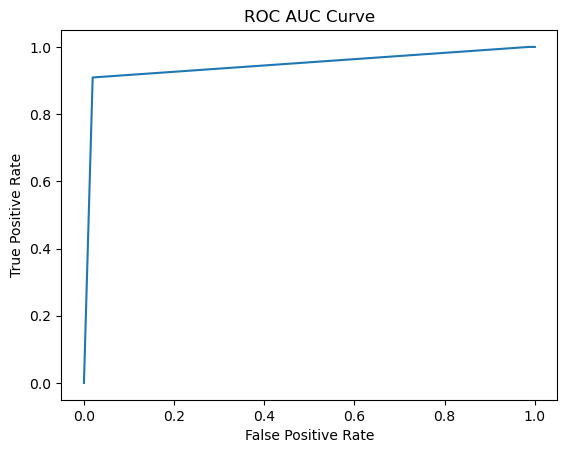

In [212]:
pickled_model = pickle.load(open("../models/Data1/1_Way/Model.pkl", 'rb'))
y_probs = pickled_model.predict_proba(np.array(X_test_cancer.to_numpy()), cols_d_cancer)
Y_ = [y_probs[i][1] for i in range(len(y_probs))]
plot_roc_curve(Y_test_cancer, Y_, "../Results/Data1/1_Way/ROC/ROC.png")
print(f'model  AUC score: {roc_auc_score(Y_test_cancer, Y_)}')

In [213]:
acc_scores1 = []
precision_scores1 = []
recall_scores1 = []
f1_scores1 = []
strtfdKFold = StratifiedKFold(n_splits=5)
for train_index, test_index in strtfdKFold.split(X_cancer, Y_cancer):
    X_train, X_test = X_cancer.iloc[train_index, :], X_cancer.iloc[test_index, :]
    Y_train, Y_test = Y_cancer[train_index], Y_cancer[test_index]

    dt1_cancer = MyDecisionTree(max_depth=5)
    dt1_cancer.fit(X_train, Y_train)
    Y_pred1_cancer = dt1_cancer.predict(np.array(X_test.to_numpy()), cols_d_cancer)

    accuracy1 = accuracy_score(Y_pred1_cancer, Y_test)
    precision1 = precision_score(Y_pred1_cancer, Y_test)
    recall1 = recall_score(Y_pred1_cancer, Y_test)
    f1 = f1_score(Y_pred1_cancer, Y_test)

    acc_scores1.append(accuracy1)
    precision_scores1.append(precision1)
    recall_scores1.append(recall1)
    f1_scores1.append(f1)
    

    print("----------")
    print("Accuracy1: ", accuracy1)
    print("Precision1: ", precision1)
    print("Recall1: ", recall1)
    print("F1-score: ", f1)
    print("Classification Report: ", classification_report(Y_pred1_cancer, Y_test))
    print("----------")

----------
Accuracy1:  0.9518072289156626
Precision1:  0.6
Recall1:  0.6
F1-score:  0.6
Classification Report:                precision    recall  f1-score   support

           0       0.97      0.97      0.97       156
           1       0.60      0.60      0.60        10

    accuracy                           0.95       166
   macro avg       0.79      0.79      0.79       166
weighted avg       0.95      0.95      0.95       166

----------
----------
Accuracy1:  0.9698795180722891
Precision1:  0.9090909090909091
Recall1:  0.7142857142857143
F1-score:  0.8
Classification Report:                precision    recall  f1-score   support

           0       0.97      0.99      0.98       152
           1       0.91      0.71      0.80        14

    accuracy                           0.97       166
   macro avg       0.94      0.85      0.89       166
weighted avg       0.97      0.97      0.97       166

----------
----------
Accuracy1:  0.9518072289156626
Precision1:  0.7272727272727

In [214]:
with open("../Results/Data1/1_Way/K_Folds/Accuracy/acc.npy",'wb') as f:
    np.save(f, np.array(acc_scores1))

with open("../Results/Data1/1_Way/K_Folds/Precision/precision.npy", 'wb') as f:
    np.save(f, np.array(precision_scores1))

with open("../Results/Data1/1_Way/K_Folds/Recall/recall.npy", 'wb') as f:
    np.save(f, np.array(recall_scores1))

with open("../Results/Data1/1_Way/K_Folds/F1_Score/f1.npy", 'wb') as f:
    np.save(f, np.array(f1_scores1))

DATASET 1 - Cancer (2-features split)

In [215]:
dt_cancer2 = MyDecisionTree2(max_depth=5)
dt_cancer2.fit(X_train_cancer, Y_train_cancer)

In [216]:
Y_pred2_cancer = dt_cancer2.predict(np.array(X_test_cancer.to_numpy()), cols_d_cancer)
accuracy2 = accuracy_score(Y_pred2_cancer, Y_test_cancer)
precision2 = precision_score(Y_pred2_cancer, Y_test_cancer)
recall2 = recall_score(Y_pred2_cancer, Y_test_cancer)
f1_2 = f1_score(Y_pred2_cancer, Y_test_cancer)
print("2-feature split accuracy: ", accuracy2)
print("2-feature split Precision: ", precision2)
print("2-feature split Recall: ", recall2)
print("2-feature split F1-Score: ", f1_2)
print("Classification Report: ")
print(classification_report(Y_pred2_cancer, Y_test_cancer))

2-feature split accuracy:  0.963855421686747
2-feature split Precision:  0.7272727272727273
2-feature split Recall:  0.7272727272727273
2-feature split F1-Score:  0.7272727272727273
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       155
           1       0.73      0.73      0.73        11

    accuracy                           0.96       166
   macro avg       0.85      0.85      0.85       166
weighted avg       0.96      0.96      0.96       166



In [217]:
pickle.dump(dt_cancer2, open("../Results/Data1/2_Way/Models_Saved/Model.pkl", 'wb'))
pickle.dump(dt_cancer2, open("../models/Data1/2_Way/Model.pkl", 'wb'))
metrics_array = np.array([accuracy2, precision2, recall2, f1_2])

with open("../Results/Data1/2_Way/Metrics/metrics.npy", 'wb') as f:
    np.save(f, metrics_array)

with open('../Results/Data1/2_Way/Y_Pred/Pred.npy', 'wb') as f:
    np.save(f, Y_pred2_cancer)


model  AUC score: 0.7712609970674487


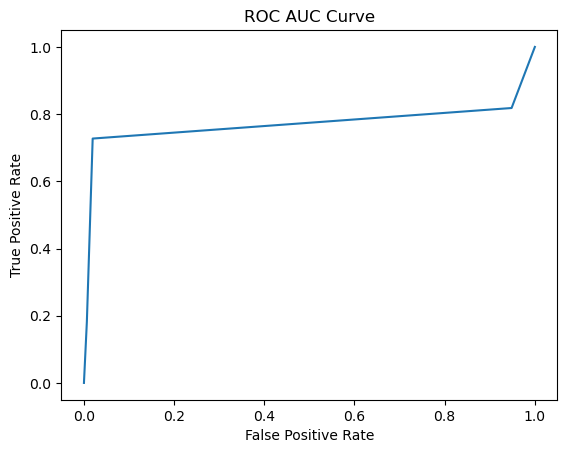

In [218]:
pickled_model = pickle.load(open("../models/Data1/2_Way/Model.pkl", 'rb'))
y_probs = pickled_model.predict_proba(np.array(X_test_cancer.to_numpy()), cols_d_cancer)
Y_ = [y_probs[i][1] for i in range(len(y_probs))]
plot_roc_curve(Y_test_cancer, Y_, "../Results/Data1/2_Way/ROC/ROC.png")
print(f'model  AUC score: {roc_auc_score(Y_test_cancer, Y_)}')

In [219]:
tree = dt_cancer2.print_tree()
visualize_tree(tree, path = '../visualizations/Tree/Data1/2_Way/Tree')

('STDs:syphilis', 'Schiller') [0.0, 0] 0
├── ('Age', 'Age') [13, 13] 1
│   ├── ('Age', 'Age') [59, 59] 5
│   │   ├── ('Age', 'Age') [52, 52] 8
│   │   │   ├── ('Age', 'Age') [50, 50] 11
│   │   │   │   ├── leaf 0 12
│   │   │   │   ├── leaf 0 13
│   │   │   │   ├── leaf 0 14
│   │   │   │   └── leaf 0 15
│   │   │   ├── leaf 0 10
│   │   │   ├── leaf 0 16
│   │   │   └── leaf 0 9
│   │   ├── leaf 0 17
│   │   ├── leaf 0 6
│   │   └── leaf 0 7
│   ├── leaf 0 2
│   ├── leaf 0 3
│   └── leaf 0 4
├── ('First sexual intercourse', 'STDs') [14.0, 0.0] 19
│   ├── ('Age', 'Age') [16, 52] 21
│   │   ├── ('Age', 'IUD (years)') [51, 7.0] 24
│   │   │   ├── ('Age', 'Age') [40, 45] 26
│   │   │   │   ├── leaf 0 29
│   │   │   │   ├── leaf 1 27
│   │   │   │   ├── leaf 1 28
│   │   │   │   └── leaf 1 30
│   │   │   ├── leaf 0 31
│   │   │   ├── leaf 1 25
│   │   │   └── leaf 1 32
│   │   ├── leaf 0 23
│   │   ├── leaf 0 33
│   │   └── leaf 1 22
│   ├── ('Age', 'Hormonal Contraceptives (years)') [18, 

In [221]:
acc_scores2 = []
precision_scores2 = []
recall_scores2 = []
f1_scores2 = []
strtfdKFold = StratifiedKFold(n_splits=5)
for train_index, test_index in strtfdKFold.split(X_cancer, Y_cancer):
    X_train, X_test = X_cancer.iloc[train_index, :], X_cancer.iloc[test_index, :]
    Y_train, Y_test = Y_cancer[train_index], Y_cancer[test_index]

    dt2_cancer = MyDecisionTree2(max_depth=5)
    dt2_cancer.fit(X_train, Y_train)
    Y_pred2_cancer = dt2_cancer.predict(np.array(X_test.to_numpy()), cols_d_cancer)

    accuracy2 = accuracy_score(Y_pred2_cancer, Y_test)
    precision2 = precision_score(Y_pred2_cancer, Y_test)
    recall2 = recall_score(Y_pred2_cancer, Y_test)
    f1_2 = f1_score(Y_pred2_cancer, Y_test)

    acc_scores2.append(accuracy2)
    precision_scores2.append(precision2)
    recall_scores2.append(recall2)
    f1_scores2.append(f1_2)

    print("----------")
    print("Accuracy2: ", accuracy2)
    print("Precision2: ", precision2)
    print("Recall2: ", recall2)
    print("F1-score2: ", f1_2)
    print("Classification Report: ") 
    print(classification_report(Y_pred2_cancer, Y_test))
    print("----------")

----------
Accuracy2:  0.9518072289156626
Precision2:  0.6
Recall2:  0.6
F1-score2:  0.6
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       156
           1       0.60      0.60      0.60        10

    accuracy                           0.95       166
   macro avg       0.79      0.79      0.79       166
weighted avg       0.95      0.95      0.95       166

----------
----------
Accuracy2:  0.9698795180722891
Precision2:  0.9090909090909091
Recall2:  0.7142857142857143
F1-score2:  0.8
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       152
           1       0.91      0.71      0.80        14

    accuracy                           0.97       166
   macro avg       0.94      0.85      0.89       166
weighted avg       0.97      0.97      0.97       166

----------
----------
Accuracy2:  0.9578313253012049
Precision2:  0.72727272727

In [222]:
with open("../Results/Data1/2_Way/K_Folds/Accuracy/acc.npy",'wb') as f:
    np.save(f, np.array(acc_scores2))

with open("../Results/Data1/2_Way/K_Folds/Precision/precision.npy", 'wb') as f:
    np.save(f, np.array(precision_scores2))

with open("../Results/Data1/2_Way/K_Folds/Recall/recall.npy", 'wb') as f:
    np.save(f, np.array(recall_scores2))

with open("../Results/Data1/2_Way/K_Folds/F1_Score/f1.npy", 'wb') as f:
    np.save(f, np.array(f1_scores2))

2nd Dataset - Fetal (For 1-feature split)

In [223]:
import warnings
warnings.filterwarnings("ignore")

In [224]:
fetal_data = pd.read_csv('../data/preprocessed-data/fetal.csv')
fetal_data.head()

,Unnamed: 0,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,0,132,0.006,0.000,0.006,0.003,0.0,0.0,17,2.1,...,68,198,6,1,141,136,140,12,0,1
1,1,133,0.003,0.000,0.008,0.003,0.0,0.0,16,2.1,...,68,198,5,1,141,135,138,13,0,1
2,2,134,0.003,0.000,0.008,0.003,0.0,0.0,16,2.4,...,53,170,11,0,137,134,137,13,1,1
3,3,132,0.007,0.000,0.008,0.000,0.0,0.0,16,2.4,...,53,170,9,0,137,136,138,11,1,1
4,4,131,0.005,0.072,0.008,0.003,0.0,0.0,28,1.4,...,88,154,5,0,135,134,137,7,1,1


In [225]:
X_fetal = fetal_data.drop(['Unnamed: 0', 'fetal_health'], axis=1)
Y_fetal = fetal_data['fetal_health']

In [226]:
X_train_fetal, X_test_fetal, Y_train_fetal, Y_test_fetal = train_test_split(X_fetal, Y_fetal, test_size=0.2, random_state = 42, stratify=Y_fetal)
print(X_train_fetal.shape)
print(np.unique(Y_train_fetal, return_counts=True))
print(np.unique(Y_test_fetal, return_counts=True))

(1690, 21)
(array([1, 2, 3], dtype=int64), array([1316,  234,  140], dtype=int64))
(array([1, 2, 3], dtype=int64), array([330,  58,  35], dtype=int64))


In [227]:
cols_fetal = X_fetal.columns
cols_d_fetal = {}
id=0
for col in cols_fetal:
    cols_d_fetal[col] = id
    id+=1

In [228]:
dt_fetal1 = MyDecisionTree(max_depth=10)
dt_fetal1.fit(X_train_fetal, Y_train_fetal)
Y_pred1_fetal = dt_fetal1.predict(np.array(X_test_fetal.to_numpy()), cols_d_fetal)
accuracy1 = accuracy_score(Y_pred1_fetal, Y_test_fetal)
precision1 = precision_score(Y_pred1_fetal, Y_test_fetal, average='weighted')
recall1 = recall_score(Y_pred1_fetal, Y_test_fetal, average='weighted')
f1 = f1_score(Y_pred1_fetal, Y_test_fetal, average='weighted')
print("One-feature split accuracy: ", accuracy1)
print("One-feature split Precision: ", precision1)
print("One-feature split Recall: ", recall1)
print("One-feature split F1-Score: ", f1)
print("Classification Report: ")
print(classification_report(Y_pred1_fetal, Y_test_fetal))

One-feature split accuracy:  0.8274231678486997
One-feature split Precision:  0.9638908033625567
One-feature split Recall:  0.8274231678486997
One-feature split F1-Score:  0.8839135393699566
Classification Report: 
              precision    recall  f1-score   support

           1       0.99      0.82      0.90       398
           2       0.03      0.50      0.06         4
           3       0.57      0.95      0.71        21

    accuracy                           0.83       423
   macro avg       0.53      0.76      0.56       423
weighted avg       0.96      0.83      0.88       423



In [229]:
pickle.dump(dt_fetal1, open("../Results/Data2/1_Way/Models_Saved/Model.pkl", 'wb'))
pickle.dump(dt_fetal1, open("../models/Data2/1_Way/Model.pkl", 'wb'))
metrics_array_fetal = np.array([accuracy1, precision1, recall1, f1])

with open('../Results/Data2/1_Way/Metrics/metrics.npy', 'wb') as f:
    np.save(f, metrics_array_fetal)
    # f.close()

with open('../Results/Data2/1_Way/Y_Pred/Pred.npy', 'wb') as f:
    np.save(f, Y_pred1_fetal)
    # f.close()


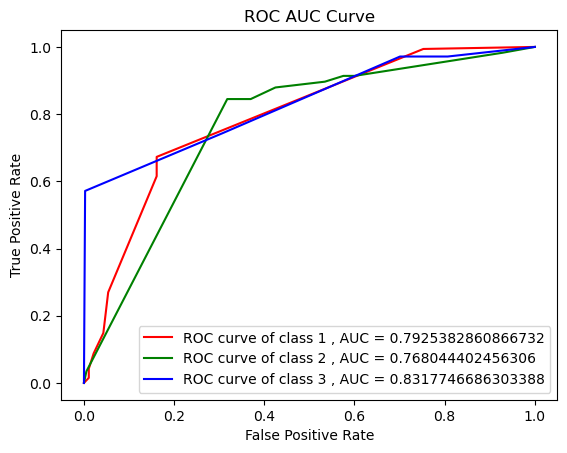

In [230]:
pickled_model = pickle.load(open("../models/Data2/1_Way/Model.pkl", 'rb'))
plot_multiclass_auc_roc(X_test_fetal, Y_test_fetal, cols_d_fetal, pickled_model, "../Results/Data2/1_Way/ROC/ROC.png")

In [231]:
tree = dt_fetal1.print_tree()

histogram_mean 89 0
├── leaf 3 1
└── percentage_of_time_with_abnormal_long_term_variability 73 2
    ├── leaf 3 54
    └── mean_value_of_short_term_variability 6.3 3
        ├── leaf 1 53
        └── mean_value_of_short_term_variability 3.3 4
            ├── histogram_mode 71 40
            │   ├── histogram_mode 90 42
            │   │   ├── baseline value 146 44
            │   │   │   ├── histogram_median 113 45
            │   │   │   │   ├── baseline value 115 47
            │   │   │   │   │   ├── baseline value 144 49
            │   │   │   │   │   │   ├── leaf 1 50
            │   │   │   │   │   │   └── leaf 1 51
            │   │   │   │   │   └── leaf 1 48
            │   │   │   │   └── leaf 3 46
            │   │   │   └── leaf 2 52
            │   │   └── leaf 2 43
            │   └── leaf 3 41
            └── mean_value_of_short_term_variability 3.1 5
                ├── mean_value_of_long_term_variability 0.0 37
                │   ├── leaf 1 39
                │   └──

In [232]:
visualize_tree(tree, path = "../visualizations/Tree/Data2/1_Way/Tree")

In [233]:
acc_scores1 = []
precision_scores1 = []
recall_scores1 = []
f1_scores1 = []
strtfdKFold = StratifiedKFold(n_splits=5)
for train_index, test_index in strtfdKFold.split(X_fetal, Y_fetal):
    X_train, X_test = X_fetal.iloc[train_index, :], X_fetal.iloc[test_index, :]
    Y_train, Y_test = Y_fetal[train_index], Y_fetal[test_index]

    dt1_fetal = MyDecisionTree(max_depth=10)
    dt1_fetal.fit(X_train, Y_train)
    Y_pred1_fetal = dt1_fetal.predict(np.array(X_test.to_numpy()), cols_d_fetal)

    accuracy1 = accuracy_score(Y_pred1_fetal, Y_test)
    precision1 = precision_score(Y_pred1_fetal, Y_test, average='weighted')
    recall1 = recall_score(Y_pred1_fetal, Y_test, average='weighted')
    f1 = f1_score(Y_pred1_fetal, Y_test, average='weighted')

    acc_scores1.append(accuracy1)
    precision_scores1.append(precision1)
    recall_scores1.append(recall1)
    f1_scores1.append(f1)

    print("----------")
    print("Accuracy1: ", accuracy1)
    print("Precision1: ", precision1)
    print("Recall1: ", recall1)
    print("F1-score: ", f1)
    print("Classification Report: ")
    print(classification_report(Y_pred1_fetal, Y_test))
    print("----------")

----------
Accuracy1:  0.7612293144208038
Precision1:  0.9456212899353031
Recall1:  0.7612293144208038
F1-score:  0.8426286665928324
Classification Report: 
              precision    recall  f1-score   support

           1       0.97      0.78      0.87       411
           2       0.02      0.08      0.03        12
           3       0.00      0.00      0.00         0

    accuracy                           0.76       423
   macro avg       0.33      0.29      0.30       423
weighted avg       0.95      0.76      0.84       423

----------
----------
Accuracy1:  0.7990543735224587
Precision1:  0.9841945288753798
Recall1:  0.7990543735224587
F1-score:  0.8754604548968972
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.79      0.89       414
           2       0.00      0.00      0.00         0
           3       0.26      1.00      0.41         9

    accuracy                           0.80       423
   macro avg       0.4

In [234]:
with open("../Results/Data2/1_Way/K_Folds/Accuracy/acc.npy",'wb') as f:
    np.save(f, np.array(acc_scores1))

with open("../Results/Data2/1_Way/K_Folds/Precision/precision.npy", 'wb') as f:
    np.save(f, np.array(precision_scores1))

with open("../Results/Data2/1_Way/K_Folds/Recall/recall.npy", 'wb') as f:
    np.save(f, np.array(recall_scores1))

with open("../Results/Data2/1_Way/K_Folds/F1_Score/f1.npy", 'wb') as f:
    np.save(f, np.array(f1_scores1))

DATASET 2 - FETAL (For 2-features split)

In [236]:
dt_fetal2 = MyDecisionTree2(max_depth=5)
dt_fetal2.fit(X_train_fetal, Y_train_fetal)

In [237]:
Y_pred2_fetal = dt_fetal2.predict(np.array(X_test_fetal.to_numpy()), cols_d_fetal)
accuracy2 = accuracy_score(Y_pred2_fetal, Y_test_fetal)
precision2 = precision_score(Y_pred2_fetal, Y_test_fetal, average='weighted')
recall2 = recall_score(Y_pred2_fetal, Y_test_fetal, average='weighted')
f1_2 = f1_score(Y_pred2_fetal, Y_test_fetal, average='weighted')
print("2-feature split accuracy: ", accuracy2)
print("2-feature split Precision: ", precision2)
print("2-feature split Recall: ", recall2)
print("2-feature split F1-Score: ", f1_2)
print("Classification Report: ")
print(classification_report(Y_pred2_fetal, Y_test_fetal))

2-feature split accuracy:  0.8108747044917257
2-feature split Precision:  0.9758005587792822
2-feature split Recall:  0.8108747044917257
2-feature split F1-Score:  0.8798400891810337
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.81      0.89       408
           2       0.00      0.00      0.00         0
           3       0.40      0.93      0.56        15

    accuracy                           0.81       423
   macro avg       0.47      0.58      0.48       423
weighted avg       0.98      0.81      0.88       423



In [238]:
pickle.dump(dt_fetal2, open("../Results/Data2/2_Way/Models_Saved/Model.pkl", 'wb'))
pickle.dump(dt_fetal2, open("../models/Data2/2_Way/Model.pkl", 'wb'))
metrics_array_fetal = np.array([accuracy2, precision2, recall2, f1_2])

with open('../Results/Data2/2_Way/Metrics/metrics.npy', 'wb') as f:
    np.save(f, metrics_array_fetal)

with open('../Results/Data2/2_Way/Y_Pred/Pred.npy', 'wb') as f:
    np.save(f, Y_pred2_fetal)


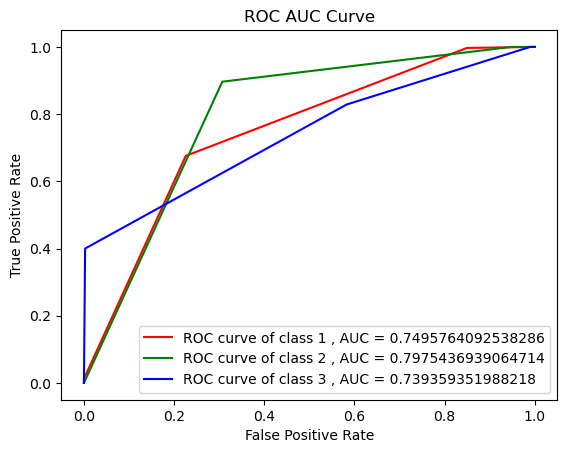

In [239]:
pickled_model = pickle.load(open("../models/Data2/2_Way/Model.pkl", 'rb'))
plot_multiclass_auc_roc(X_test_fetal, Y_test_fetal, cols_d_fetal, pickled_model, "../Results/Data2/2_Way/ROC/ROC.png")

In [240]:
tree = dt_fetal2.print_tree()

('percentage_of_time_with_abnormal_long_term_variability', 'histogram_mean') [73, 89] 0
├── ('mean_value_of_short_term_variability', 'histogram_mean') [6.3, 180] 3
│   ├── ('abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability') [83, 0] 5
│   │   ├── ('baseline value', 'histogram_median') [159, 86] 7
│   │   │   ├── ('baseline value', 'histogram_median') [158, 91] 10
│   │   │   │   ├── leaf 1 11
│   │   │   │   ├── leaf 1 13
│   │   │   │   ├── leaf 1 14
│   │   │   │   └── leaf 2 12
│   │   │   ├── leaf 1 15
│   │   │   ├── leaf 1 8
│   │   │   └── leaf 3 9
│   │   ├── ('mean_value_of_short_term_variability', 'histogram_variance') [4.1, 87] 16
│   │   │   ├── ('mean_value_of_short_term_variability', 'histogram_variance') [3.0, 82] 18
│   │   │   │   ├── leaf 1 19
│   │   │   │   ├── leaf 1 20
│   │   │   │   ├── leaf 1 21
│   │   │   │   └── leaf 1 22
│   │   │   ├── leaf 1 17
│   │   │   ├── leaf 1 23
│   │   │   └── leaf 1 24
│   │   ├── leaf 1 

In [241]:
visualize_tree(tree, path = "../visualizations/Tree/Data2/2_Way/Tree")

In [242]:
acc_scores2 = []
precision_scores2 = []
recall_scores2 = []
f1_scores2 = []
strtfdKFold = StratifiedKFold(n_splits=5)
for train_index, test_index in strtfdKFold.split(X_fetal, Y_fetal):
    X_train, X_test = X_fetal.iloc[train_index, :], X_fetal.iloc[test_index, :]
    Y_train, Y_test = Y_fetal[train_index], Y_fetal[test_index]

    dt2_fetal = MyDecisionTree2(max_depth=5)
    dt2_fetal.fit(X_train, Y_train)
    Y_pred2_fetal = dt2_fetal.predict(np.array(X_test.to_numpy()), cols_d_fetal)

    accuracy2 = accuracy_score(Y_pred2_fetal, Y_test)
    precision2 = precision_score(Y_pred2_fetal, Y_test, average='weighted')
    recall2 = recall_score(Y_pred2_fetal, Y_test, average='weighted')
    f1_2 = f1_score(Y_pred2_fetal, Y_test, average='weighted')

    acc_scores2.append(accuracy2)
    precision_scores2.append(precision2)
    recall_scores2.append(recall2)
    f1_scores2.append(f1_2)

    print("----------")
    print("Accuracy2: ", accuracy2)
    print("Precision2: ", precision2)
    print("Recall2: ", recall2)
    print("F1-score: ", f1_2)
    print("Classification Report: ")
    print(classification_report(Y_pred2_fetal, Y_test))
    print("----------")

----------
Accuracy2:  0.7635933806146572
Precision2:  0.9433892430224051
Recall2:  0.7635933806146572
F1-score:  0.8418466085132751
Classification Report: 
              precision    recall  f1-score   support

           1       0.97      0.78      0.87       410
           2       0.02      0.08      0.03        12
           3       0.03      1.00      0.06         1

    accuracy                           0.76       423
   macro avg       0.34      0.62      0.32       423
weighted avg       0.94      0.76      0.84       423

----------
----------
Accuracy2:  0.7990543735224587
Precision2:  0.9841945288753798
Recall2:  0.7990543735224587
F1-score:  0.8754604548968972
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.79      0.89       414
           2       0.00      0.00      0.00         0
           3       0.26      1.00      0.41         9

    accuracy                           0.80       423
   macro avg       0.4

In [243]:
with open("../Results/Data2/2_Way/K_Folds/Accuracy/acc.npy",'wb') as f:
    np.save(f, np.array(acc_scores2))

with open("../Results/Data2/2_Way/K_Folds/Precision/precision.npy", 'wb') as f:
    np.save(f, np.array(precision_scores2))

with open("../Results/Data2/2_Way/K_Folds/Recall/recall.npy", 'wb') as f:
    np.save(f, np.array(recall_scores2))

with open("../Results/Data2/2_Way/K_Folds/F1_Score/f1.npy", 'wb') as f:
    np.save(f, np.array(f1_scores2))

DATASET 3 - BANKING (FOR 1-feature split)

In [244]:
df_banking = pd.read_csv("../data/preprocessed-data/dataset3.csv")

In [245]:
X_banking = df_banking.drop(['Unnamed: 0', 'y'], axis=1)
Y_banking = df_banking['y'].to_numpy()
X_train_banking, X_test_banking, Y_train_banking, Y_test_banking = train_test_split(X_banking, Y_banking, test_size=0.2, random_state=42, stratify=Y_banking)
print(X_train_banking.shape)

(32940, 63)


In [246]:
dt_banking1 = MyDecisionTree(max_depth=5, num_random_columns=30)
dt_banking1.fit(X_train_banking, Y_train_banking)

In [247]:
cols_banking = X_banking.columns
cols_d_banking = {}
id=0
for col in cols_banking:
    cols_d_banking[col] = id
    id+=1

# Y_pred_banking

In [248]:
Y_pred1_banking = dt_banking1.predict(np.array(X_test_banking.to_numpy()), cols_d_banking)
accuracy1 = accuracy_score(Y_pred1_banking, Y_test_banking)
precision1 = precision_score(Y_pred1_banking, Y_test_banking)
recall1 = recall_score(Y_pred1_banking, Y_test_banking)
f1 = f1_score(Y_pred1_banking, Y_test_banking)
print("One-feature split accuracy: ", accuracy1)
print("One-feature split Precision: ", precision1)
print("One-feature split Recall: ", recall1)
print("One-feature split F1-Score: ", f1)
print("Classification Report: ")
print(classification_report(Y_pred1_banking, Y_test_banking))

One-feature split accuracy:  0.8873239436619719
One-feature split Precision:  0.0
One-feature split Recall:  0.0
One-feature split F1-Score:  0.0
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8236
           1       0.00      0.00      0.00         0

    accuracy                           0.89      8236
   macro avg       0.50      0.44      0.47      8236
weighted avg       1.00      0.89      0.94      8236



In [249]:
pickle.dump(dt_banking1, open("../Results/Data3/1_Way/Models_Saved/Model.pkl", 'wb'))
pickle.dump(dt_banking1, open("../models/Data3/1_Way/Model.pkl", 'wb'))
metrics_array_banking = np.array([accuracy1, precision1, recall1, f1])

with open('../Results/Data3/1_Way/Metrics/metrics.npy', 'wb') as f:
    np.save(f, metrics_array_banking)
    f.close()

with open('../Results/Data3/1_Way/Y_Pred/Pred.npy', 'wb') as f:
    np.save(f, Y_pred1_banking)
    f.close()


model  AUC score: 0.5775189683483382


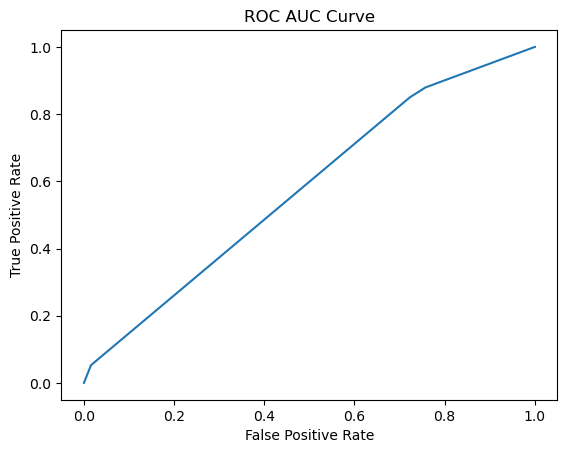

In [250]:
pickled_model = pickle.load(open("../models/Data3/1_Way/Model.pkl", 'rb'))
y_probs = pickled_model.predict_proba(np.array(X_test_banking.to_numpy()), cols_d_banking)
Y_ = [y_probs[i][1] for i in range(len(y_probs))]
plot_roc_curve(Y_test_banking, Y_, "../Results/Data3/1_Way/ROC/ROC.png")
print(f'model  AUC score: {roc_auc_score(Y_test_banking, Y_)}')

In [251]:
tree = dt_banking1.print_tree()

job_self-employed 0 0
├── leaf 0 14
└── previous 6 1
    ├── job_student 0 2
    │   ├── campaign 12 8
    │   │   ├── leaf 0 12
    │   │   └── previous 4 9
    │   │       ├── leaf 0 10
    │   │       └── leaf 1 11
    │   └── job_blue-collar 0 3
    │       ├── age 71 5
    │       │   ├── leaf 0 6
    │       │   └── leaf 0 7
    │       └── leaf 0 4
    └── leaf 0 13



In [252]:
visualize_tree(tree, path = "../visualizations/Tree/Data3/1_Way/Tree")

In [269]:
acc_scores1 = []
precision_scores1 = []
recall_scores1 = []
f1_scores1 = []
strtfdKFold = StratifiedKFold(n_splits=5)
for train_index, test_index in strtfdKFold.split(X_banking, Y_banking):
    X_train, X_test = X_banking.iloc[train_index, :], X_banking.iloc[test_index, :]
    Y_train, Y_test = Y_banking[train_index], Y_banking[test_index]

    dt1_banking = MyDecisionTree(max_depth=5, num_random_columns=30)
    dt1_banking.fit(X_train, Y_train)
    Y_pred1_banking = dt1_banking.predict(np.array(X_test.to_numpy()), cols_d_banking)

    accuracy1 = accuracy_score(Y_pred1_banking, Y_test)
    precision1 = precision_score(Y_pred1_banking, Y_test)
    recall1 = recall_score(Y_pred1_banking, Y_test)
    f1 = f1_score(Y_pred1_banking, Y_test)

    acc_scores1.append(accuracy1)
    precision_scores1.append(precision1)
    recall_scores1.append(recall1)
    f1_scores1.append(f1)

    print("----------")
    print("Accuracy1: ", accuracy1)
    print("Precision1: ", precision1)
    print("Recall1: ", recall1)
    print("F1-score: ", f1)
    print("Classification Report: ") 
    print(classification_report(Y_pred1_banking, Y_test))
    print("----------")

----------
Accuracy1:  0.8953375424963574
Precision1:  0.15732758620689655
Recall1:  0.6460176991150443
F1-score:  0.2530329289428076
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      8010
           1       0.16      0.65      0.25       226

    accuracy                           0.90      8236
   macro avg       0.57      0.77      0.60      8236
weighted avg       0.97      0.90      0.92      8236

----------
----------
Accuracy1:  0.8876745598057073
Precision1:  0.002157497303128371
Recall1:  1.0
F1-score:  0.004305705059203444
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8233
           1       0.00      1.00      0.00         2

    accuracy                           0.89      8235
   macro avg       0.50      0.94      0.47      8235
weighted avg       1.00      0.89      0.94      8235

----------
----------
Accuracy1

In [271]:
with open("../Results/Data3/1_Way/K_Folds/Accuracy/acc.npy",'wb') as f:
    np.save(f, np.array(acc_scores1))

with open("../Results/Data3/1_Way/K_Folds/Precision/precision.npy", 'wb') as f:
    np.save(f, np.array(precision_scores1))

with open("../Results/Data3/1_Way/K_Folds/Recall/recall.npy", 'wb') as f:
    np.save(f, np.array(recall_scores1))

with open("../Results/Data3/1_Way/K_Folds/F1_Score/f1.npy", 'wb') as f:
    np.save(f, np.array(f1_scores1))

DATASET 3 - BANKING (FOR 2-features split)

In [258]:
dt_banking2 = MyDecisionTree2(max_depth=5, num_random_columns=15)
dt_banking2.fit(X_train_banking, Y_train_banking)

142 0 0 0
117 0 0 0
507 0 0 0
101 0 0 0
2369 0 0 0
122 0 0 0


In [260]:
Y_pred2_banking = dt_banking2.predict(np.array(X_test_banking.to_numpy()), cols_d_banking)
accuracy2 = accuracy_score(Y_pred2_banking, Y_test_banking)
precision2 = precision_score(Y_pred2_banking, Y_test_banking)
recall2 = recall_score(Y_pred2_banking, Y_test_banking)
f1_2 = f1_score(Y_pred2_banking, Y_test_banking)
print("One-feature split accuracy: ", accuracy2)
print("One-feature split Precision: ", precision2)
print("One-feature split Recall: ", recall2)
print("One-feature split F1-Score: ", f1_2)
print("Classification Report: ")
print(classification_report(Y_pred2_banking, Y_test_banking))

One-feature split accuracy:  0.8980087421078193
One-feature split Precision:  0.16702586206896552
One-feature split Recall:  0.6981981981981982
One-feature split F1-Score:  0.26956521739130435
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.95      8014
           1       0.17      0.70      0.27       222

    accuracy                           0.90      8236
   macro avg       0.58      0.80      0.61      8236
weighted avg       0.97      0.90      0.93      8236



In [261]:
pickle.dump(dt_banking2, open("../Results/Data3/2_Way/Models_Saved/Model.pkl", 'wb'))
pickle.dump(dt_banking2, open("../models/Data3/2_Way/Model.pkl", 'wb'))
metrics_array_banking = np.array([accuracy2, precision2, recall2, f1_2])

with open('../Results/Data3/2_Way/Metrics/metrics.npy', 'wb') as f:
    np.save(f, metrics_array_banking)
    f.close()

with open('../Results/Data3/2_Way/Y_Pred/Pred.npy', 'wb') as f:
    np.save(f, Y_pred2_banking)
    f.close()


model  AUC score: 0.6737275989468319


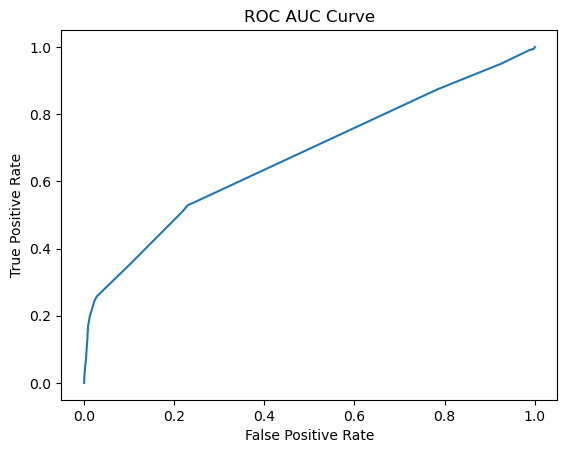

In [262]:
pickled_model = pickle.load(open("../models/Data3/2_Way/Model.pkl", 'rb'))
y_probs = pickled_model.predict_proba(np.array(X_test_banking.to_numpy()), cols_d_banking)
Y_ = [y_probs[i][1] for i in range(len(y_probs))]
plot_roc_curve(Y_test_banking, Y_, "../Results/Data3/2_Way/ROC/ROC.png")
print(f'model  AUC score: {roc_auc_score(Y_test_banking, Y_)}')

In [263]:
tree = dt_banking2.print_tree()

('poutcome_nonexistent', 'poutcome_failure') [0, 0] 0
├── ('day_of_week_fri', 'month_may') [0, 0] 2
│   ├── ('euribor3m', 'day_of_week_wed') [4.12, 0] 3
│   │   ├── ('education_high.school', 'education_high.school') [0, 0] 18
│   │   │   ├── ('marital_married', 'duration') [0, 90] 26
│   │   │   │   ├── leaf 0 28
│   │   │   │   ├── leaf 1 27
│   │   │   │   ├── leaf 1 29
│   │   │   │   └── leaf 1 30
│   │   │   ├── ('month_oct', 'duration') [0, 71] 21
│   │   │   │   ├── leaf 0 23
│   │   │   │   ├── leaf 1 22
│   │   │   │   ├── leaf 1 24
│   │   │   │   └── leaf 1 25
│   │   │   ├── leaf 1 19
│   │   │   └── leaf 1 20
│   │   ├── ('marital_single', 'duration') [0, 59] 4
│   │   │   ├── ('housing_yes', 'job_housemaid') [0, 0] 12
│   │   │   │   ├── leaf 0 15
│   │   │   │   ├── leaf 0 16
│   │   │   │   ├── leaf 1 13
│   │   │   │   └── leaf 1 14
│   │   │   ├── ('previous', 'job_blue-collar') [6, 0] 7
│   │   │   │   ├── leaf 0 10
│   │   │   │   ├── leaf 0 11
│   │   │   │   ├── l

In [265]:
visualize_tree(tree, path = "../visualizations/Tree/Data3/2_Way/Tree")

In [266]:
acc_scores2 = []
precision_scores2 = []
recall_scores2 = []
f1_scores2 = []
strtfdKFold = StratifiedKFold(n_splits=5)
for train_index, test_index in strtfdKFold.split(X_banking, Y_banking):
    X_train, X_test = X_banking.iloc[train_index, :], X_banking.iloc[test_index, :]
    Y_train, Y_test = Y_banking[train_index], Y_banking[test_index]

    dt2_banking = MyDecisionTree2(max_depth=5, num_random_columns=15)
    dt2_banking.fit(X_train, Y_train)
    Y_pred2_banking = dt2_banking.predict(np.array(X_test.to_numpy()), cols_d_banking)

    accuracy2 = accuracy_score(Y_pred2_banking, Y_test)
    precision2 = precision_score(Y_pred2_banking, Y_test)
    recall2 = recall_score(Y_pred2_banking, Y_test)
    f1_2 = f1_score(Y_pred2_banking, Y_test)

    acc_scores2.append(accuracy2)
    precision_scores1.append(precision2)
    recall_scores2.append(recall2)
    f1_scores2.append(f1_2)

    print("----------")
    print("Accuracy2: ", accuracy2)
    print("Precision2: ", precision2)
    print("Recall2: ", recall2)
    print("F1-score2: ", f1_2)
    print("Classification Report: ")
    print(classification_report(Y_pred2_banking, Y_test))
    print("----------")

31 0 0 0
3318 0 0 0
425 0 0 0
37 0 0 0
5 0 0 0
8 0 0 0
3 0 0 0
10 0 0 0
15 0 0 0
3 0 0 0
9 0 0 0
7 0 0 0
4 0 0 0
61 0 0 0
----------
Accuracy2:  0.8926663428848955
Precision2:  0.18211206896551724
Recall2:  0.5748299319727891
F1-score2:  0.2765957446808511
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7942
           1       0.18      0.57      0.28       294

    accuracy                           0.89      8236
   macro avg       0.58      0.74      0.61      8236
weighted avg       0.95      0.89      0.92      8236

----------
7 0 0 0
9 0 0 0
5 0 0 0
7 0 0 0
8 0 0 0
9 0 0 0
69 0 0 0
----------
Accuracy2:  0.8910746812386157
Precision2:  0.14670981661272922
Recall2:  0.5619834710743802
F1-score2:  0.23267750213858
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      7993
           1       0.15      0.56      0.23       242

   

In [268]:
with open("../Results/Data3/2_Way/K_Folds/Accuracy/acc.npy",'wb') as f:
    np.save(f, np.array(acc_scores2))

with open("../Results/Data3/2_Way/K_Folds/Precision/precision.npy", 'wb') as f:
    np.save(f, np.array(precision_scores2))

with open("../Results/Data3/2_Way/K_Folds/Recall/recall.npy", 'wb') as f:
    np.save(f, np.array(recall_scores2))

with open("../Results/Data3/2_Way/K_Folds/F1_Score/f1.npy", 'wb') as f:
    np.save(f, np.array(f1_scores2))